# Personalized Cancer Diagnosis

## Description

### Data Description

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

###  objectives and constraints

* No low-latency requirement.
* Errors are costly.
* We have to interpret results.
* Probabilities for each class is required.

## Preprocessing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from tqdm import tqdm

### Reading Data

In [2]:
data = pd.read_csv('Data/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


* **ID** : Case ID
* **Gene** : The Gene where genetic mutation is located.
* **Variation** : Amino acid change for this mutation.
* **Class** : To the class in which this genetic mutation has been classified.

In [3]:
# note the seprator in this file
data_text =pd.read_csv("Data/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


* **ID** : Case ID
* **Text** : Clinical observation of genetic mutation.

In [4]:
# combaining above both
data = pd.merge(data, data_text, on='ID', how='left')
data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


### Text Preprocessing

In [5]:
stop_words = set(stopwords.words('english'))

def preprocess_text(sentence):
    
    sentence = str(sentence)
    res = ''
    
    # replacing all charcters othar than alphabets and numerical
    text = re.sub('[^a-zA-Z0-9\n]', ' ', sentence)
    # replacing double space
    text = re.sub('\s+', ' ', sentence)
    
    text = text.lower()
    for word in text.split():
        if not word in stop_words:
            res = res + ' ' + word 
    return res

In [6]:
for i, sentence in enumerate(data['TEXT']):
    if type(sentence) == str:
        data['TEXT'][i] = preprocess_text(sentence)
    else:
        print("There is no text description for index: ", i)

There is no text description for index:  1109
There is no text description for index:  1277
There is no text description for index:  1407
There is no text description for index:  1639
There is no text description for index:  2755


In [7]:
data[data.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [8]:
data = data.dropna(axis=0)

### Train, test and validation split

splitting data into train, test and validation in ratio (64:20:16)

In [9]:
Y = data['Class']
data = data.drop(['Class'], axis=1)

In [10]:
from sklearn.model_selection import train_test_split

# splitting data frame by maintaining same distribution
X_train, test_x, Y_train, test_y = train_test_split(data, Y, stratify=Y, test_size=0.2)
train_x, cv_x, train_y, cv_y = train_test_split(X_train, Y_train, stratify=Y_train, test_size=0.2)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(lowercase=False)
onehotGene_train = bow.fit_transform(train_x['Gene'].values)
onehotGene_cv = bow.transform(cv_x['Gene'].values)
onehotGene_test = bow.transform(test_x['Gene'].values)

In [12]:
bow = CountVectorizer(max_features=200, lowercase=False)
onehot_variance_train = bow.fit_transform(train_x['Variation'].values)
onehot_variance_cv = bow.transform(cv_x['Variation'].values)
onehot_variance_test = bow.transform(test_x['Variation'].values)

In [13]:
onehot_variance_train = onehot_variance_train.toarray()
onehot_variance_cv = onehot_variance_cv.toarray()
onehot_variance_test = onehot_variance_test.toarray()

In [14]:
# converting text to tfidf values
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1500)
tfidf_train = vectorizer.fit_transform(train_x['TEXT'])
tfidf_cv = vectorizer.transform(cv_x['TEXT'])
tfidf_test = vectorizer.transform(test_x['TEXT'])

In [15]:
# joining data
from scipy.sparse import hstack

bias = np.ones((tfidf_train.shape[0], 1))
x_train = hstack((onehotGene_train, onehot_variance_train, tfidf_train, bias))

bias = np.ones((tfidf_cv.shape[0], 1))
x_cv = hstack((onehotGene_cv, onehot_variance_cv, tfidf_cv, bias))

bias = np.ones((tfidf_test.shape[0], 1))
x_test = hstack((onehotGene_test, onehot_variance_test, tfidf_test, bias))

In [16]:
y_train = np.array(list(train_y))
y_cv = np.array(list(cv_y))
y_test = np.array(list(test_y))

# Machine Learning Models

## Logistic Regression

### with class balancing

for alpha = 1e-06
Log Loss : 1.08202057650655
for alpha = 1e-05
Log Loss : 1.0640206557046237
for alpha = 0.0001
Log Loss : 0.9990230788720578
for alpha = 0.001
Log Loss : 1.0180659813146962
for alpha = 0.01
Log Loss : 1.1378043586584758
for alpha = 0.1
Log Loss : 1.255509042147323
for alpha = 1
Log Loss : 1.4663611151281057
for alpha = 10
Log Loss : 1.546204981530604
for alpha = 100
Log Loss : 1.5553276213116385


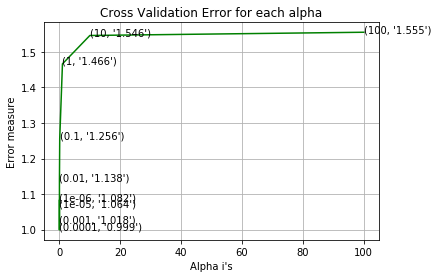

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log',
                        random_state=0)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    sig_clf_probs = sig_clf.predict_proba(x_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs))
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [18]:
loss_main = 0.9990230788720578

In [19]:
removed_indices = []
# Backward selection :: dropping performence dimnishing features from variance
for i in tqdm(range(onehot_variance_train.shape[1])):
    
    bias = np.ones((onehot_variance_train.shape[0], 1))
    x_train = hstack((onehotGene_train, 
                      np.delete(onehot_variance_train, i, axis=1), 
                      tfidf_train, bias))

    bias = np.ones((onehot_variance_cv.shape[0], 1))
    x_cv = hstack((onehotGene_cv, 
                   np.delete(onehot_variance_cv, i, axis=1), 
                   tfidf_cv, bias))
    
    clf = SGDClassifier(class_weight='balanced', alpha=0.0001, penalty='l2', loss='log',
                        random_state=0)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    sig_clf_probs = sig_clf.predict_proba(x_cv)
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    loss = log_loss(y_cv, sig_clf_probs)
    
    if loss_main - loss >= 0.001:
        
        print("New loss is: ", loss)
        loss_main = loss
        
        onehot_variance_train = np.delete(onehot_variance_train, i, axis=1)
        onehot_variance_cv = np.delete(onehot_variance_cv, i, axis=1)
        
        removed_indices.append(i)
    
    if i == onehot_variance_train.shape[1] - 1:
        break

 50%|█████     | 101/200 [01:59<01:59,  1.21s/it]

New loss is:  0.9977311783324515


 99%|█████████▉| 198/200 [03:59<00:02,  1.28s/it]

In [21]:
onehot_variance_test.shape

(664, 200)

In [22]:
for i in removed_indices:
    onehot_variance_test = np.delete(onehot_variance_test, i, axis=1)

In [23]:
onehot_variance_test.shape

(664, 199)

In [24]:
bias = np.ones((tfidf_train.shape[0], 1))
x_train = hstack((onehotGene_train, onehot_variance_train, tfidf_train, bias))

bias = np.ones((tfidf_cv.shape[0], 1))
x_cv = hstack((onehotGene_cv, onehot_variance_cv, tfidf_cv, bias))

bias = np.ones((tfidf_test.shape[0], 1))
x_test = hstack((onehotGene_test, onehot_variance_test, tfidf_test, bias))

In [25]:
from sklearn.metrics import confusion_matrix

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log Loss : 1.0393073430552604
Log loss (train) on the stacking classifier : 0.7329711034241039
Log loss (CV) on the stacking classifier : 0.9977311783324515
Log loss (test) on the stacking classifier : 1.0393073430552604
Number of missclassified point : 0.3689759036144578
-------------------- Confusion matrix --------------------


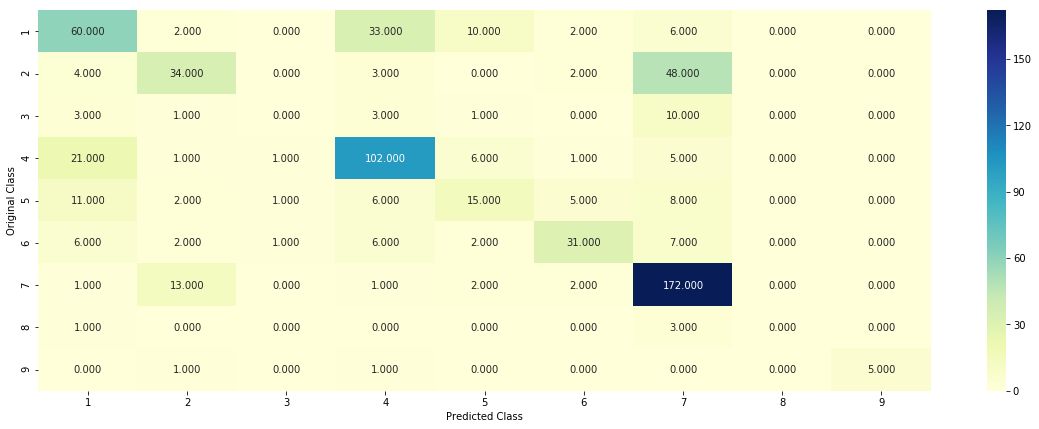

-------------------- Precision matrix (Columm Sum=1) --------------------


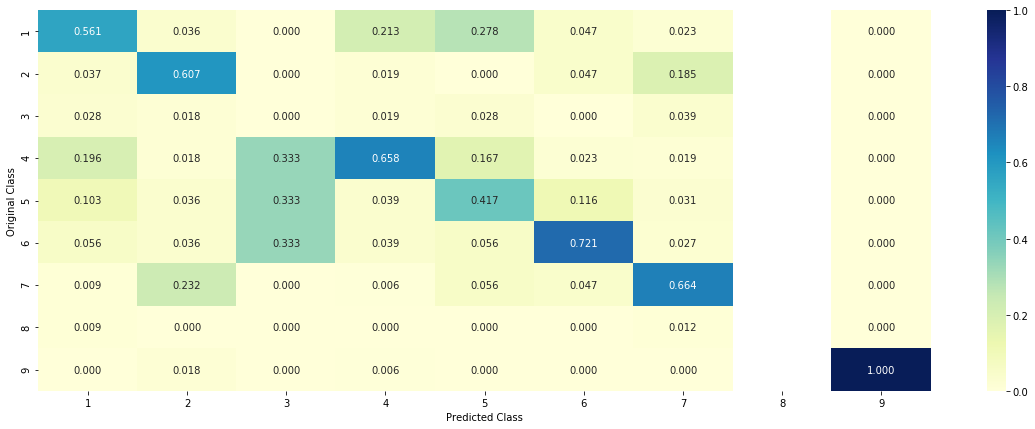

-------------------- Recall matrix (Row sum=1) --------------------


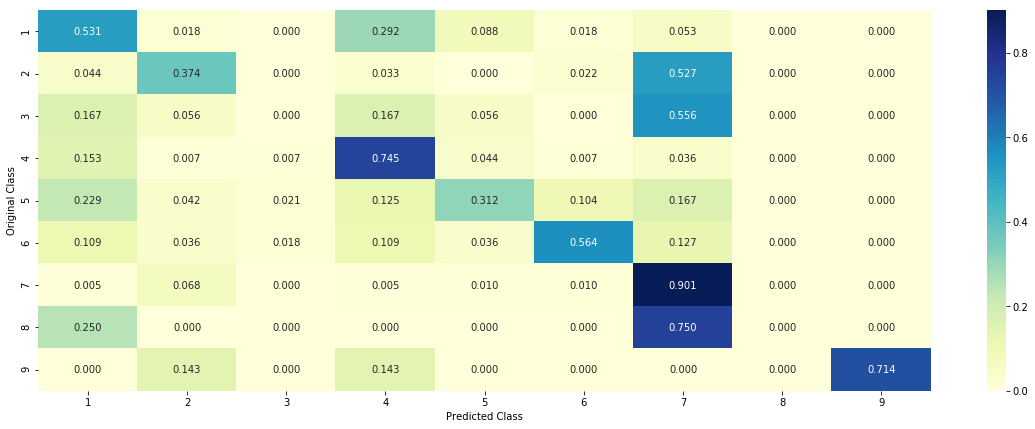

In [26]:
# final model
clf = SGDClassifier(class_weight='balanced', alpha=0.0001, penalty='l2', loss='log',
                    random_state=0)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)
sig_clf_probs = sig_clf.predict_proba(x_test)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(y_test, sig_clf_probs))

log_error1 = log_loss(y_train, sig_clf.predict_proba(x_train))
print("Log loss (train) on the stacking classifier :",log_error1)

log_error2 = log_loss(y_cv, sig_clf.predict_proba(x_cv))
print("Log loss (CV) on the stacking classifier :",log_error2)

log_error3 = log_loss(y_test, sig_clf.predict_proba(x_test))
print("Log loss (test) on the stacking classifier :",log_error3)

num_misclassified = np.count_nonzero((sig_clf.predict(x_test)- y_test))/y_test.shape[0]
print("Number of missclassified point :", num_misclassified)
plot_confusion_matrix(test_y=y_test, predict_y=sig_clf.predict(x_test))

Feature Importance

In [55]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer(max_features=200, lowercase=False)
    text_count_vec = TfidfVectorizer(max_features=1500)
    
    gene_vec = gene_count_vec.fit(train_x['Gene'].values)
    var_vec  = var_count_vec.fit(train_x['Variation'].values)
    text_vec = text_count_vec.fit(train_x['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

#### Correctly Classified point

In [58]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', 
                    alpha=0.0001, penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train)
test_point_index = 32
no_feature = 200
predicted_cls = sig_clf.predict(x_train.tocsr()[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", 
      np.round(sig_clf.predict_proba(x_train.tocsr()[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     test_x['TEXT'].iloc[test_point_index],
                     test_x['Gene'].iloc[test_point_index],
                     test_x['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0069 0.1536 0.0022 0.0135 0.0229 0.0032 0.7908 0.0029 0.004 ]]
Actual Class : 7
--------------------------------------------------
2 Text feature [isolated] present in test data point [True]
8 Text feature [thus] present in test data point [True]
9 Text feature [activating] present in test data point [True]
12 Text feature [cell] present in test data point [True]
14 Text feature [signal] present in test data point [True]
15 Text feature [catalytic] present in test data point [True]
17 Text feature [mutagenesis] present in test data point [True]
20 Text feature [next] present in test data point [True]
32 Text feature [luciferase] present in test data point [True]
34 Text feature [standard] present in test data point [True]
35 Text feature [critical] present in test data point [True]
39 Text feature [mutant] present in test data point [True]
42 Text feature [hematopoietic] present in test data point [True]
45 Text feature [expressed]

#### Incorrectly Classified point

In [59]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', 
                    alpha=0.0001, penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train)
test_point_index = 45
no_feature = 200
predicted_cls = sig_clf.predict(x_train.tocsr()[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", 
      np.round(sig_clf.predict_proba(x_train.tocsr()[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     test_x['TEXT'].iloc[test_point_index],
                     test_x['Gene'].iloc[test_point_index],
                     test_x['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 3
Predicted Class Probabilities: [[0.0781 0.0123 0.344  0.2144 0.1574 0.1755 0.0142 0.0028 0.0015]]
Actual Class : 1
--------------------------------------------------
5 Text feature [differentiation] present in test data point [True]
7 Text feature [msi] present in test data point [True]
8 Text feature [recombinant] present in test data point [True]
15 Text feature [pcr] present in test data point [True]
16 Text feature [erbb3] present in test data point [True]
17 Text feature [mutational] present in test data point [True]
21 Text feature [background] present in test data point [True]
24 Text feature [values] present in test data point [True]
27 Text feature [variant] present in test data point [True]
29 Text feature [remains] present in test data point [True]
30 Text feature [suppressor] present in test data point [True]
34 Text feature [negative] present in test data point [True]
36 Text feature [days] present in test data point [True]
39 Text feature [truncating] 

# Conclusion

- Steps followed:
    * Considered most important 300 values in variance column.
    * Considered most important 2000 words from text.
    * Added Bias.

* Obtained 0.997 log error for cv dataset with alpha value 0.0001.
* Obtained 1.03 log error for test dataset with alpha value 0.0001.